# Описание задания

Управление портфелем ценных бумаг необходимо для успешного сохранения и преумножения свободного капитала, которым обладает финансовая компания

Процесс активного управления портфелем ценных бумаг можно условно разделить на стратегический и тактический:
* Стратегическое управление нацелено на выбор класса активов для достижения желаемого соотношения риск-доходность. Например, акции регулируемых компаний электроэнергетического сектора могут быть включены в портфель для снижения рыночного риска.
* Цель тактического управления состоит в выборе таких компаний электроэнергетического сектора, которые бы максимизировали финансовый результат портфеля.

Процесс тактического управления на практике осложняется существованиям ряда несовершенств финансовых рынков, таких как наличие брокерской комиссии, которую необходимо платить при каждой ребалансировке портфеля. Поэтому, тактическое управление портфелем ценных бумаг представляет собой задачу оптимального управления.

В данном задании предлагается реализовать решение упрощенной задачи тактического управления портфелем ценных бумаг с помощью глубокого Q-обучения обучения. В качестве доступных финансовых активов рассматриваются следующие:
* Обыкновенные акции компании Public Service Enterprise Group ("PEG")
* Обыкновенные акции компании Consolidated Edison ("ED")
* Обыкновенные акции компании Eversource Energy ("ES")
* Безрисковый актив с фиксированной доходностью 1.0% годовых ("rf")

Для обучения AI агента, осуществляющего оптимальное тактическое управление портфелем, была собрана выборка дневных наблюдений за период с 1 июля 2008 г. по 30 декабря 2016 г. Данные включают в себя цены акций, а также набор предиктивных факторов, которые могут быть полезны для предсказания доходности акций. Брокерская комиссия составляет 0.05% от размера сделки.

Цель тактического управления портфелем – максимизировать коэффициент Шарпа (т.е. риск-взвешенную доходность портфеля). Формула расчета коэффициента Шарпа имеет следующий вид:
![Коэффициент Шарпа](Pic1.png)

# Задание

### Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import itertools as it

from tabulate import tabulate
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Dense, LSTM, concatenate
from keras import backend as K

K.set_session(tf.Session())

Using TensorFlow backend.


### Параметры обучения

In [2]:
# Безрисковая процентная ставка на 1 год
risk_free = 0.01

# Брокерская комиссия в размере 0.05% от размера сделки
transaction_cost = 0.0005

# Количество рабочих дней в году
trading_days = 250                          

# Параметр адаптации дифференциального коэффициента Шарпа (задает ширину скользящего окна)
theta = 0.02

# Параметр скорости обучения
learn_rate = 0.1

# Коэффициент дисконтирования будущей доходности
gamma = np.exp(-risk_free/trading_days)

# Количество рекуррентных ячеек в Q-сети
rnn_layers = 5

# Ширина скрытого слоя Q-сети
n_hidden = 15

# Размер батча для обучения Q-сети
batch_size = 64

# Процедура идентификации: ε-greedy с убыванием до ε=0.001 в течение 1000 эпизодов
Epsilon_decay_periods = 1000
Epsilon_start = 1.000
Epsilon_end = 0.001

### Загрузка предиктивных факторов

В качестве предиктивных факторов используются следующий показатели:
* Цены на нефть, газ, уголь и уран
* Кривая ставок гос. облигаций США
* Финансовые индексы S&P 500, VIX и 5-летняя ожидаемая инфляция
* Средняя температура, скорость ветра и уровень осадков в регионе
* Дневной прогноз спроса и рыночные цены на электроэнергию

In [3]:
Features = pd.read_csv('Features.csv', parse_dates = ['date_']).set_index('date_')

# Лог-дифференцирование временных рядов для повышения их стационарности
Features['SP500_Adj_Close'] = np.log(Features['SP500_Adj_Close']) - np.log(Features['SP500_Adj_Close'].shift(1))
Features['WTI'] = np.log(Features['WTI']) - np.log(Features['WTI'].shift(1))
Features['Natural_Gas'] = np.log(Features['Natural_Gas']) - np.log(Features['Natural_Gas'].shift(1))
Features['Coal_Price'] = np.log(Features['Coal_Price']) - np.log(Features['Coal_Price'].shift(1))
Features['Uranium_Price'] = np.log(Features['Uranium_Price']) - np.log(Features['Uranium_Price'].shift(1))
Features['VIX'] = np.log(Features['VIX']) - np.log(Features['VIX'].shift(1))
Features['Electricity_NE_Price'] = (np.log(Features['Electricity_NE_Price']) - 
                                    np.log(Features['Electricity_NE_Price'].shift(1)))
Features['Electricity_PJM_Price'] = (np.log(Features['Electricity_PJM_Price']) - 
                                     np.log(Features['Electricity_PJM_Price'].shift(1)))
Features['Temperature'] = np.log(Features['Temperature']) - np.log(Features['Temperature'].shift(1))
Features['Wind_Speed'] = np.log(1+Features['Wind_Speed']) - np.log(1+Features['Wind_Speed'].shift(1))
Features['Precipitation'] = np.log(1+Features['Precipitation']) - np.log(1+Features['Precipitation'].shift(1))
Features['Load_Forecast'] = np.log(Features['Load_Forecast']) - np.log(Features['Load_Forecast'].shift(1))

Features.dropna(inplace=True)
Features.head()

,SP500_Adj_Close,WTI,Natural_Gas,Coal_Price,Uranium_Price,UST_1y,UST_Slope,VIX,Inflation_5y_Exp,Electricity_NE_Price,Electricity_PJM_Price,Temperature,Wind_Speed,Precipitation,Load_Forecast
date_,,,,,,,,,,,,,,,
2008-07-02,-0.018371,0.018276,-0.008627,0.0,0.0,0.0234,0.0019,0.091652,0.0242,-0.007901,0.080151,0.004228,0.047628,0.112267,-0.004136
2008-07-03,0.001093,0.011909,0.013944,0.0,0.0,0.0228,0.0019,-0.044978,0.0242,0.067153,0.100545,-0.014165,0.645519,-0.112267,0.012909
2008-07-07,-0.008421,-0.027351,-0.045199,0.0,0.0,0.0225,0.0019,0.039562,0.0241,0.083348,0.048790,0.074210,-1.074515,-0.009950,0.016248
2008-07-08,0.016936,-0.038432,-0.048066,0.0,0.0,0.0224,0.0020,-0.107604,0.0240,0.091936,-0.120249,0.017072,0.762140,0.000000,0.092003
2008-07-09,-0.023040,0.000074,-0.029706,0.0,0.0,0.0216,0.0020,0.086039,0.0238,-0.263185,-0.152461,-0.014426,0.110348,0.009950,0.003237


### Загрузка цен финансовых активов

In [33]:
PEG = pd.read_csv('Prices_PEG.csv', parse_dates = ['Date'])
ED = pd.read_csv('Prices_ED.csv', parse_dates = ['Date'])
ES = pd.read_csv('Prices_ES.csv', parse_dates = ['Date'])

# Расчет дневных доходностей акций
PEG['PEG'] = np.log(PEG['Adj Close']) - np.log(PEG['Adj Close'].shift(1))
ED['ED'] = np.log(ED['Adj Close']) - np.log(ED['Adj Close'].shift(1))
ES['ES'] = np.log(ES['Adj Close']) - np.log(ES['Adj Close'].shift(1))

# Расчет дневной доходности безрискового актива 
rf = pd.Series(len(Features.index)*[np.exp(risk_free/trading_days)-1], index = Features.index, name = 'rf')

# Сопоставление доходностей с предиктивными факторами
PEG = PEG.set_index('Date')['PEG'].loc[Features.index]
ED = ED.set_index('Date')['ED'].loc[Features.index]
ES = ES.set_index('Date')['ES'].loc[Features.index]

# Объединение доходностей в один DataFrame
Returns = pd.DataFrame([PEG, ED, ES, rf]).T
Returns.head()

,PEG,ED,ES,rf
date_,,,,
2008-07-02,-0.004294,-0.009852,-0.024702,0.00004
2008-07-03,-0.006261,-0.005487,-0.007972,0.00004
2008-07-07,-0.023886,-0.004464,-0.010054,0.00004
2008-07-08,-0.014070,0.021092,0.023963,0.00004
2008-07-09,0.002246,0.005140,0.016439,0.00004


### Выделение обучающей и тестовой выборки

В качестве тестовой выборки будут использоваться данные за 2016 г.

In [5]:
# Дата, с которой начинается тестовый период
test_split_date = '2016-01-01'

# Количество наблюдений в обучающей выборке
train_samples_num = len(Returns[Returns.index < test_split_date].index)

### Дискретизация допустимых структур портфеля 

Для упрощения задачи предполагается, что структура портфеля ценных бумаг может принимать небольшое количество дискретных значений. С этой целью рассматриваются всевозможные сочетания из 4-х активов, в которых портфель разбивается пропорционально. Количество допустимых структур портфеля при таком подходе может быть посчитано по формуле:
![Коэффициент Шарпа](Pic2.png)

In [6]:
Asset_list = ['PEG', 'ED', 'ES', 'rf']

# Генерация всевозможных сочетаний из 4-х активов
Asset_combinations = []
for i in range(1, len(Asset_list)+1):
    Asset_combinations.extend(it.combinations(Asset_list, i))

# Пропорциональное разбиение портфеля для каждого сочетания
Actions_list = []
for Asset_combination in Asset_combinations:
    Action = dict((a, 0) for a in Asset_list)
    for a in Asset_combination:
        Action[a] = 1 / len(Asset_combination)
    Actions_list.append(Action)
Actions = pd.DataFrame(Actions_list)

# Вывод множества допустимых структур портфеля 
print ("Допустимые веса активов в портфеле:")
Actions

Допустимые веса активов в портфеле:


,ED,ES,PEG,rf
0,0.000000,0.000000,1.000000,0.000000
1,1.000000,0.000000,0.000000,0.000000
2,0.000000,1.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,1.000000
4,0.500000,0.000000,0.500000,0.000000
5,0.000000,0.500000,0.500000,0.000000
6,0.000000,0.000000,0.500000,0.500000
7,0.500000,0.500000,0.000000,0.000000
8,0.500000,0.000000,0.000000,0.500000
9,0.000000,0.500000,0.000000,0.500000


In [7]:
Asset_combinations

[('PEG',),
 ('ED',),
 ('ES',),
 ('rf',),
 ('PEG', 'ED'),
 ('PEG', 'ES'),
 ('PEG', 'rf'),
 ('ED', 'ES'),
 ('ED', 'rf'),
 ('ES', 'rf'),
 ('PEG', 'ED', 'ES'),
 ('PEG', 'ED', 'rf'),
 ('PEG', 'ES', 'rf'),
 ('ED', 'ES', 'rf'),
 ('PEG', 'ED', 'ES', 'rf')]

In [8]:
a = ['a', 'b', 'c', 'd']
it.combinations(Asset_list, 1)

### Функция создания рекуррентной Q-сети

В качестве Q-сети используется гибридная рекуррентная нейронная сеть:
* Предиктивные факторы подаются на рекуррентный слой LSTM, поскольку они обладают свойством частичной наблюдаемости (т.е. их прошлые значения также могут являться сигналами роста или падения стоимости финансовых активов).
* Текущая конфигурации портфеля подается на Dense слой, потому что она известна достоверно.
Архитектура Q-сети изображена на следующем графике:
![Архитектура Q-сети](Pic3.png)

In [9]:
def create_Q_network(features_num, assets_num, rnn_layers, n_hidden, actions_num):
    
    # Входной слой сети
    Factors = Input(shape=(1, features_num), name='Factors')
    Portfolio_Structure = Input(shape=(assets_num, ), name='Portfolio_Structure')

    # Первый слой сети (конкатенация LSTM и Dense слоев)
    Factors_first_layer = LSTM(rnn_layers)(Factors)
    Portfolio_Structure_first_layer = Dense(assets_num)(Portfolio_Structure)
    first_layer = concatenate([Factors_first_layer, Portfolio_Structure_first_layer])

    #####################################################################
    #################### Начало оцениваемого задания ####################
    #####################################################################
    
    # Создайте второй слой сети. Тип слоя - Dense. Функция активации - relu. Ширина - n_hidden.
    
    second_layer = Dense(n_hidden, activation='relu', name='second_layer')(first_layer)
    
    #####################################################################
    #################### Конец оцениваемого задания #####################
    #####################################################################
    
    # Выходной слой сети
    output_layer = Dense(actions_num, activation='relu', name='output_layer')(second_layer)

    # Компиляция модели
    model = Model(inputs=[Factors, Portfolio_Structure], outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam())
    
    return model

### Функция вычисления дифференциального коэффициента Шарпа

В процессе обучения Q-сети в качестве функции наград удобно использовать дифференциальный коэффициент Шарпа. По сути это обычный коэффициент Шарпа, но посчитанный на некотором скользящем окне прошлых наблюдений. Ширина окна регулируется параметром адаптации theta.

In [10]:
def differential_sharpe_ratio(R1, A0, B0, theta):   
    dA1 = R1 - A0
    dB1 = R1**2 - B0
    
    A1 = A0 + theta*dA1
    B1 = B0 + theta*dB1
    
    if ((B0 - A0**2) != 0):
        D1 = (B0*dA1 - 0.5*A0*dB1) / ((B0 - A0**2)**(3/2))
    else:
        D1 = 0
    
    return D1, A1, B1

In [11]:
Actions.iloc[1]

ED     1.0
ES     0.0
PEG    0.0
rf     0.0
Name: 1, dtype: float64

### Реализация алгоритма глубокого Q-обучения

In [15]:
# Фиксируем seed генераторов случайных чисел
np.random.seed(1234)
tf.set_random_seed(1234)

#####################################################################
#################### Начало оцениваемого задания ####################
#####################################################################

# Cоздайте Q-сеть со следующими параметрами:
# Количество предиктивных признаков features_num = len(Features.columns)
# Количество доступных активов assets_num = len(Actions.columns)
# Количество рекуррентных ячеек в Q-сети rnn_layers = rnn_layers
# Ширина скрытого слоя Q-сети n_hidden = n_hidden
# Количество допустимых действий actions_num = len(Actions.index)

features_num = len(Features.columns)
assets_num = len(Actions.columns)
rnn_layers = rnn_layers
n_hidden = n_hidden
actions_num = len(Actions.index)

Q_network = create_Q_network(features_num, assets_num, rnn_layers, n_hidden, actions_num)

# #####################################################################
# #################### Конец оцениваемого задания #####################
# #####################################################################

# # Проводим обучение Q-сети на 10 эпизодах
# print("Начало обучения.\n")
# iter_num = 0
# for episode in range(1, 11):
    
#     # Начальная конфигурация портфеля: 100% безрисковый актив
#     last_state = Actions.iloc[3]
#     A0, B0 = risk_free, risk_free**2
    
#     # Обнуляем накопленную погрешность обучения Q-сети
#     loss = 0
    
#     # Итерация по батчам в каждом эпизоде
#     for i in range(0, train_samples_num - 1, batch_size):
        
#         # Массивы для хранения совершенных действий и целевых Q-значений
#         a_list, target_list = [], []
        
#         # Обновление показателя ε в процедуре идентификации
#         iter_num += 1
#         Epsilon = Epsilon_start + (Epsilon_end - Epsilon_start) * min(iter_num / Epsilon_decay_periods, 1)
        
#         # Итерация по наблюдениям в каждом батче
#         for j in range(i, min(i + batch_size, train_samples_num - 1)):
            
#             # Предсказание сегодняшних Q-значений с помощью текущей версии Q-сети
#             Q_targets = Q_network.predict({'Factors': Features.iloc[j].values.reshape((1, 1, len(Features.iloc[j]))), 
#                                            'Portfolio_Structure': last_state.values.reshape((1, len(last_state)))})[0]
            
#             # Реализация ε-greedy процедуры идентификации
#             if (np.random.random() < Epsilon):
                
#                 #####################################################################
#                 #################### Начало оцениваемого задания ####################
#                 #####################################################################
                
#                 # Реализуйте выбор случайного действия из массива Actions. Используйте функцию np.random.choice.
#                 # Сохраните индекс данного действия в массиве Actions, а также само действие (конфигурацию портфеля)
                
#                 a_index = np.random.choice(Actions.index)
#                 a = Actions.iloc[a_index]
                
#                 #####################################################################
#                 #################### Конец оцениваемого задания #####################
#                 #####################################################################
                                
#             else:
#                 a_index = np.argmax(Q_targets)
#                 a = Actions.loc[a_index]
            
#             # Вычисление размера брокерской комиссии за ребалансировку портфеля
#             delta_weights = abs(a - last_state)
#             transaction_costs = transaction_cost * delta_weights 
            
#             # Вычисление доходности финансовых активов в портфеле
#             portfolio_returns = np.multiply(a, Returns.iloc[j])
            
#             # Вычисление чистой доходности портфеля
#             r = np.sum(portfolio_returns - transaction_costs)

#             # Вычисление дифференциального коэффициента Шарпа
#             D1, A0, B0 = differential_sharpe_ratio(r, A0, B0, theta)   

#             # Предсказание завтрашних Q-значений с помощью текущей версии Q-сети
#             Q1 = Q_network.predict({'Factors': Features.iloc[j+1].values.reshape((1, 1, len(Features.iloc[j+1]))), 
#                                     'Portfolio_Structure': a.values.reshape((1, len(a)))})[0]

#             # Оценка погрешности обучения Q-сети
#             loss += abs(D1 + gamma * np.max(Q1) - Q_targets[a_index])
            
#             #####################################################################
#             #################### Начало оцениваемого задания ####################
#             #####################################################################

#             # Вычислите целевые Q-значения на основе уравнения обновления.
#             # Используйте переменную D1 в качестве текущей награды.
#             # Не забудьте учесть параметр скорости обучения.
            
#             Q_targets[a_index] = Q_targets[a_index] + learning_rate*(D1 + gamma * np.max(Q1) - Q_targets[a_index])

#             #####################################################################
#             #################### Конец оцениваемого задания #####################
#             #####################################################################
            
#             # Сохранение совершенных действий и целевых Q-значений
#             a_list.append(list(last_state))
#             target_list.append(Q_targets)            
            
#             # Сохранение последней конфигурации портфеля
#             last_state = a.copy()

#         # Сопоставление предиктивных факторов с полученным батчем наблюдений
#         train_features = Features.iloc[i : min(i + batch_size, train_samples_num - 1)]
#         train_features = train_features.values.reshape((train_features.shape[0], 1, train_features.shape[1]))
        
#         # Дообучение Q-сети на полученном батче наблюдений
#         Q_network.train_on_batch(x = {'Factors': train_features,
#                                       'Portfolio_Structure': np.array(a_list)},
#                                  y = np.array(target_list))
        
#     print ('Эпизод ' + str(episode) + '. Погрешность обучения Q-cети %0.3f.' % (loss / (train_samples_num - 1)))

# print("\nОбучение на заданном количестве эпизодов завершено")

# Анализ эффективности AI агента на тестовом периоде

### Загрузка предобученной модели

Поскольку качественное обучение Q-сети занимает большое количество времени, в дальнейшем анализе мы воспользуемся заранее предобученной моделью на большом количестве эпизодов.

In [16]:
Q_network.load_weights("model.h5")
print ("Предобученная модель успешно загружена")

Предобученная модель успешно загружена


###  Получение действий AI агента и вычисление доходностей управляемого портфеля

In [17]:
action_tracker = []
test_portfolio_r = []

# Начальная конфигурация портфеля: 100% безрисковый актив
last_state = Actions.iloc[3]

# Итерация по каждому дню тестового периода
for i in range(train_samples_num, len(Features.index)):
    
    # Предсказание Q-значений с помощью обученной Q-сети
    Q_targets = Q_network.predict({'Factors': Features.iloc[i].values.reshape((1, 1, len(Features.iloc[i]))), 
                                   'Portfolio_Structure': last_state.values.reshape((1, len(last_state)))})[0]
    
    # Выбор наилучшей конфигурации портфеля
    a_index = np.argmax(Q_targets)
    a = Actions.loc[a_index]
    
    # Сохранение выбранной конфигурации портфеля
    action_tracker.append(a)
    
    # Вычисление размера брокерской комиссии за ребалансировку портфеля
    delta_weights = abs(a - last_state)
    transaction_costs = transaction_cost * delta_weights 
    
    # Вычисление доходности финансовых активов в портфеле
    portfolio_returns = np.multiply(a, Returns.iloc[i])
       
    # Сохранение чистой дневной доходности портфеля
    test_portfolio_r.append(np.sum(portfolio_returns - transaction_costs))
    
test_portfolio_r = pd.Series(test_portfolio_r)

### Анализ периода владения активами в процессе управления портфелем

Поскольку AI агент стремится максимизировать риск-взвешенную доходность портфеля, то он осуществляет его ребалансировку только в том случае, если наблюдается достаточно сильный сигнал продолжительного роста стоимости финансовых активов. В противном случае, AI агент предпочитает держать капитал в безрисковом активе.

In [18]:
pd.concat(action_tracker).rename('Период владения, %').reset_index().groupby(['index']).mean()

,"Период владения, %"
index,
ED,0.005952
ES,0.041667
PEG,0.047619
rf,0.904762


### Создание бенчмарка и вычисление его доходностей

В качестве бенчмарка рассматривается пассивная инвестиция в 4 доступных актива в равных пропорциях. Цель создания бенчмарка - проверить, сможет ли AI агент показать результаты лучше, чем простая альтернативная инвестиционная стратегия, доступная каждому инвестору.

In [19]:
test_benchmark_value = pd.Series([0.25, 0.25, 0.25, 0.25], index = Returns.columns)
test_benchmark_r = []

# Итерация по каждому дню тестового периода
for i in range(train_samples_num, len(Features.index)):

    # Вычисление дневной доходности бенчмарка
    r_b = np.sum(test_benchmark_value * (1.0 + Returns.iloc[i])) / np.sum(test_benchmark_value) - 1.0
    
    # Вычисление результирующей стоимости бенчмарка
    test_benchmark_value = test_benchmark_value * (1.0 + Returns.iloc[i])
        
    # Сохранение дневной доходности бенчмарка
    test_benchmark_r.append(r_b)

test_benchmark_r = pd.Series(test_benchmark_r)

In [30]:
Returns.iloc[1]

PEG   -0.006261
ED    -0.005487
ES    -0.007972
rf     0.000040
Name: 2008-07-03 00:00:00, dtype: float64

In [29]:
Returns.iloc[1] + 1.0

PEG    0.993739
ED     0.994513
ES     0.992028
rf     1.000040
Name: 2008-07-03 00:00:00, dtype: float64

In [35]:
np.sum(test_benchmark_value*(Returns.iloc[1]))

-0.005598890250742593

In [34]:
np.sum(test_benchmark_value * (1.0 + Returns.iloc[1])) / np.sum(test_benchmark_value) - 1.0

-0.0050469030597574127

### График дневых доходностей портфеля против бенчмарка

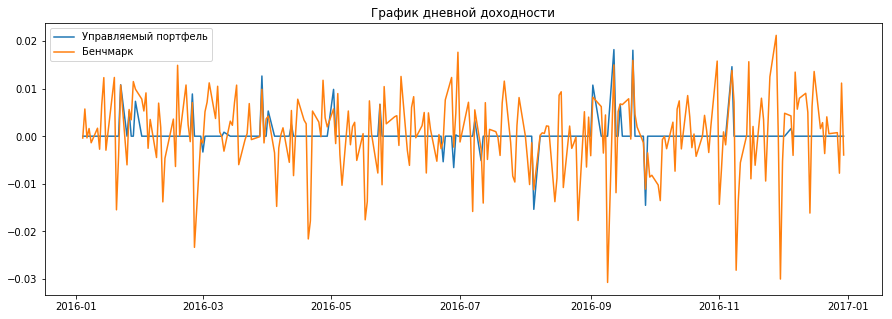

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(Returns.iloc[train_samples_num:].index, test_portfolio_r, label = 'Управляемый портфель')
ax.plot(Returns.iloc[train_samples_num:].index, test_benchmark_r, label = 'Бенчмарк')
ax.legend()
plt.title('График дневной доходности')
plt.show()

### Анализ финансового результата управления портфелем

Доходность управляемого портфеля оказалась сопоставима с бенчмарком. Однако AI агент сумел добиться меньшей волатильности портфеля, в результате чего он получил значительно более высокий Коэффициент Шарпа.

In [36]:
# Вычисление доходностей портфелей
portfolio_total_return = np.prod(1.0 + test_portfolio_r) - 1.0
benchmark_total_return = np.prod(1.0 + test_benchmark_r) - 1.0

# Вычисление стандартных отклонений портфелей
portfolio_std = np.std(test_portfolio_r) * np.sqrt(len(test_portfolio_r))
benchmark_std = np.std(test_benchmark_r) * np.sqrt(len(test_benchmark_r))

# Вычисление коэффициентов Шарпа портфелей
portfolio_sharpe_ratio = (portfolio_total_return - risk_free) / portfolio_std
benchmark_sharpe_ratio = (benchmark_total_return - risk_free) / benchmark_std

# Вывод таблицы с результатами
print(tabulate([['Доходность', '%0.1f%%' % (100*benchmark_total_return), '%0.1f%%' % (100*portfolio_total_return)],
                ['Ст. отклонение', '%0.1f%%' % (100*benchmark_std), '%0.1f%%' % (100*portfolio_std)],
                ['Коэффициент Шарпа', '%0.2f' % benchmark_sharpe_ratio, '%0.2f' % portfolio_sharpe_ratio]],
               headers = ['', 'Бенчмарк', 'Управляемый портфель']))

                   Бенчмарк    Управляемый портфель
-----------------  ----------  ----------------------
Доходность         10.9%       10.7%
Ст. отклонение     13.0%       4.7%
Коэффициент Шарпа  0.76        2.09
